### 【目的】 不均衡データに対して、オーバーサンプリング&ダウンサンプリングを行うことで、精度改善を検証する。

**オーバーサンプリング&ダウンサンプリングには、複数の手法があり、どれが最適かはデータの性質に依存するので、検証する必要あり。**

#### オーバーサンプリング
- ADASYN
- ROS
- SMOTE


<参考>
- [imbalanced-learn API](https://imbalanced-learn.readthedocs.io/en/stable/api.html?highlight=imblearn%20over_sampling#module-imblearn.over_sampling)
- [解説編：オーバーサンプリング手法解説](https://qiita.com/eigs/items/8ae0970afe188a1124d1)
- [不均衡データに対するClassification](https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92)
- [機械学習における不均衡データの扱い方](https://qiita.com/r-takahama/items/631a59953fc20ceaf5d9)




In [13]:
import numpy as np
import numpy.random as random
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from imblearn.datasets import fetch_datasets
from imblearn.over_sampling import *
from imblearn.under_sampling import *

from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline
from collections import Counter

from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced
from yellowbrick.target import class_balance

##  
**データの取得**

In [14]:
ecoli = fetch_datasets()['ecoli']             # チュートリアル
isolet = fetch_datasets()['isolet']           # 特徴量が617個で最多
mammography = fetch_datasets()['mammography'] # 特徴量が6個で最少
arrhythmia = fetch_datasets()['arrhythmia']   # データ数が452と少ない割に特徴量が多い
abalone_19 = fetch_datasets()['abalone_19']   # 不均衡度が最大

##  
**データの可視化(0次元と1次元に着目)**

In [15]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

##  
**何もしないFakesamplerを作成**

In [16]:
# Make an identity sampler
from imblearn.base import BaseSampler
class FakeSampler(BaseSampler):

    _sampling_type = 'bypass'

    def _fit_resample(self, X, y):
        return X, y

##  
**classification_report_imbalanced**
- precision
- recall
- specificity
- geometric mean
- index balanced accuracy

##  
**オーバーサンプリング**

In [34]:
def oversampling_and_classify(X, y):
        
    samplers = [FakeSampler(),
                RandomOverSampler(random_state=0),
                SMOTE(random_state=0),
                ADASYN(random_state=0)]
    
    fig, axs = plt.subplots(len(samplers)//2, 2, figsize=(15, 15))
    ax_res = np.array(axs).reshape(-1).tolist()

    for ax, sampler in zip(ax_res, samplers):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

        print('----- {} -----'.format(sampler.__class__.__name__))
        print('Training target statistics: {}'.format(Counter(y_train)))
        print('Testing target statistics: {}'.format(Counter(y_test)))

        clf = make_pipeline(sampler, LinearSVC())
        clf.fit(X_train, y_train)
        plot_resampling(X, y, sampler, ax)
        ax.set_title('Resampling using {}'.format(sampler.__class__.__name__))
            
        print(classification_report_imbalanced(y_test, clf.predict(X_test)))
        
        # ２次元データでないと描画できないので今回は使用しない
        # plot_decision_function(X, y, clf, ax_de) 
        
    
    fig.tight_layout()
    plt.show()

##  
**アンダーサンプリング**

In [60]:
def undersampling_and_classify(X, y):
    
    samplers = [FakeSampler(),
                RandomUnderSampler(),
                ClusterCentroids(), 
                NearMiss(),
                AllKNN(),
                EditedNearestNeighbours(),
                RepeatedEditedNearestNeighbours(),
                CondensedNearestNeighbour(), 
                OneSidedSelection(),
                NeighbourhoodCleaningRule(),
                InstanceHardnessThreshold(),]
    
    fig, axs = plt.subplots(len(samplers)//2, 2, figsize=(15, 30))
    ax_res = np.array(axs).reshape(-1).tolist()
    
    for ax, sampler in zip(ax_res, samplers):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#         print('----- {} -----'.format(sampler.__class__.__name__))
#         print('Training target statistics: {}'.format(Counter(y_train)))
#         print('Testing target statistics: {}'.format(Counter(y_test)))
        
        plot_resampling(X, y, sampler, ax)
        ax.set_title('Resampling using {}'.format(sampler.__class__.__name__))    
    
        # Pipeline
        clf = make_pipeline(sampler, LinearSVC())
        clf.fit(X_train, y_train)
        
        # X_res, y_res = sampler.fit_resample(X_train, y_train)
        # clf = LinearSVC()
        # clf.fit(X_res, y_res)
    
        # class_balance(y_train=y_train, y_test=y_res, ax=ax_class, show=False)
            
        print(classification_report_imbalanced(y_test, clf.predict(X_test)))
        
    
    fig.tight_layout()
    plt.show()

## Ecoli
oversamplingの方が効いている。

----- FakeSampler -----
Training target statistics: Counter({-1: 224, 1: 28})
Testing target statistics: Counter({-1: 77, 1: 7})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.96      0.96      0.57      0.96      0.74      0.57        77
          1       0.57      0.57      0.96      0.57      0.74      0.53         7

avg / total       0.93      0.93      0.60      0.93      0.74      0.57        84

----- RandomOverSampler -----
Training target statistics: Counter({-1: 224, 1: 28})
Testing target statistics: Counter({-1: 77, 1: 7})
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.90      1.00      0.95      0.95      0.89        77
          1       0.47      1.00      0.90      0.64      0.95      0.91         7

avg / total       0.96      0.90      0.99      0.92      0.95      0.89        84

----- SMOTE -----
Training target statistics: Counter({-1: 224, 1:

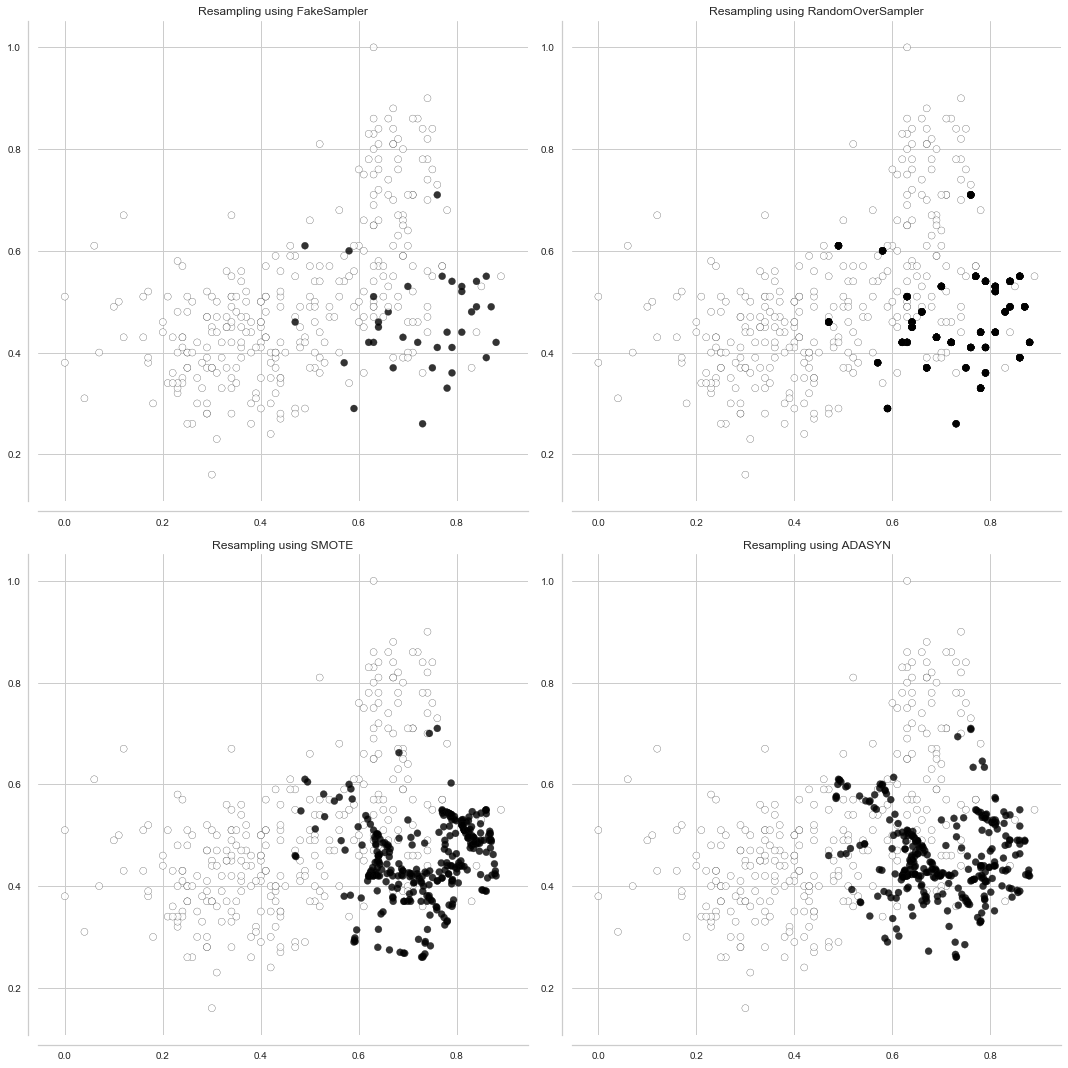

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.96      0.96      0.57      0.96      0.74      0.57        77
          1       0.57      0.57      0.96      0.57      0.74      0.53         7

avg / total       0.93      0.93      0.60      0.93      0.74      0.57        84

                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.88      1.00      0.94      0.94      0.87        77
          1       0.44      1.00      0.88      0.61      0.94      0.89         7

avg / total       0.95      0.89      0.99      0.91      0.94      0.87        84



/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.82      1.00      0.90      0.90      0.80        77
          1       0.33      1.00      0.82      0.50      0.90      0.83         7

avg / total       0.94      0.83      0.98      0.87      0.90      0.81        84

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.58      0.86      0.73      0.71      0.49        77
          1       0.16      0.86      0.58      0.27      0.71      0.51         7

avg / total       0.91      0.61      0.83      0.69      0.71      0.49        84

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.94      0.86      0.96      0.90      0.81        77
          1       0.55      0.86      0.94      0.67      0.90      0.80         7

avg / total       0.95      0.93      0.86      0.94      0.90      0.81       

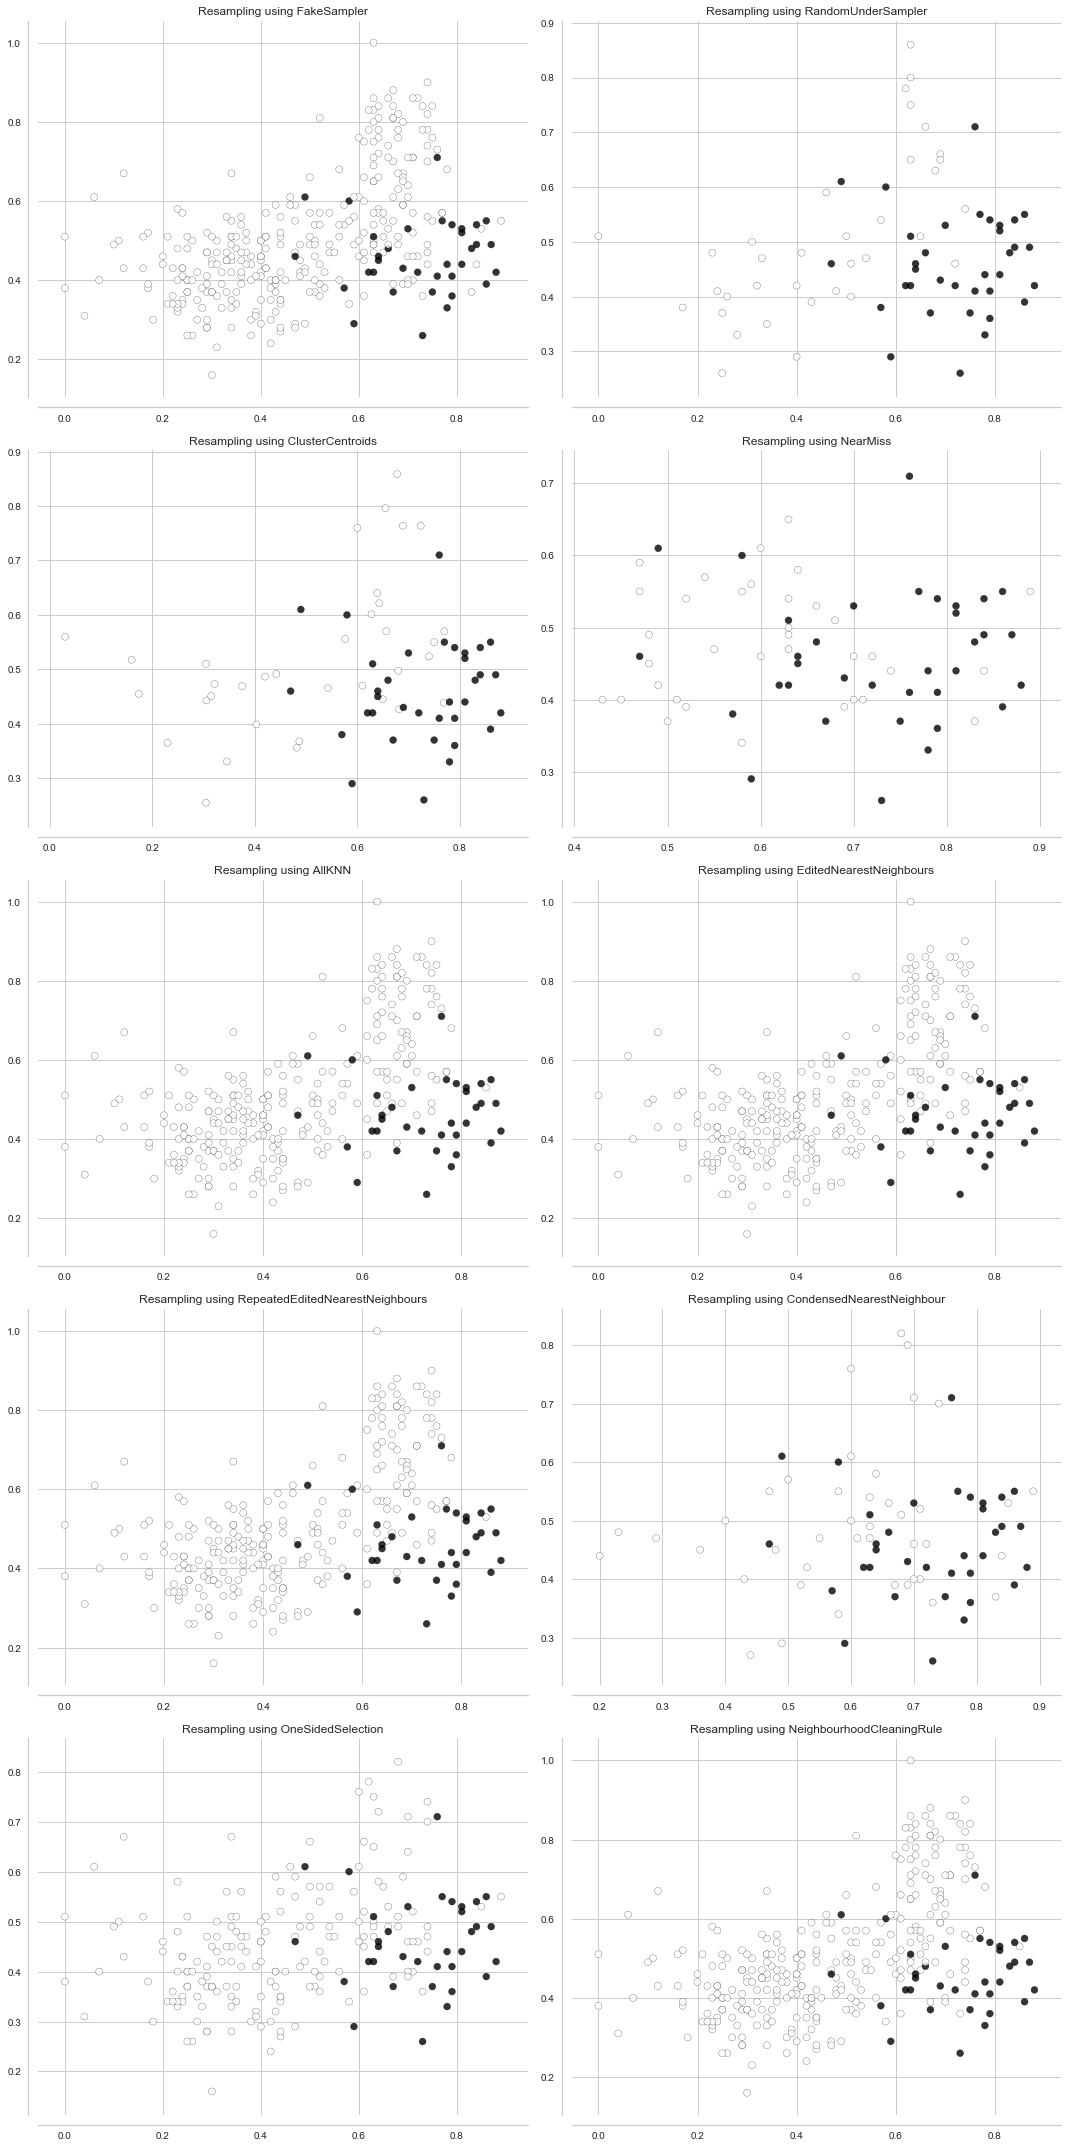

In [62]:
X, y = ecoli.data, ecoli.target

oversampling_and_classify(X,y)

undersampling_and_classify(X,y)

## Isolet
undersamplingの方が効いている。

----- FakeSampler -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.98      0.78      0.98      0.88      0.78      1812
          1       0.76      0.78      0.98      0.77      0.88      0.75       138

avg / total       0.97      0.97      0.80      0.97      0.88      0.78      1950

----- RandomOverSampler -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.98      0.80      0.98      0.88      0.79      1812
          1       0.73      0.80      0.98      0.76      0.88      0.77       138

avg / total       0.97      0.96      0.81      0.97      0.88      0.79      1950

----- SMOTE -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.98      0.79      0.98      0.88      0.79      1812
          1       0.73      0.79      0.98      0.76      0.88      0.76       138

avg / total       0.97      0.96      0.80      0.96      0.88      0.78      1950

----- ADASYN -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.98      0.79      0.98      0.88      0.79      1812
          1       0.74      0.79      0.98      0.76      0.88      0.76       138

avg / total       0.97      0.97      0.80      0.97      0.88      0.79      1950



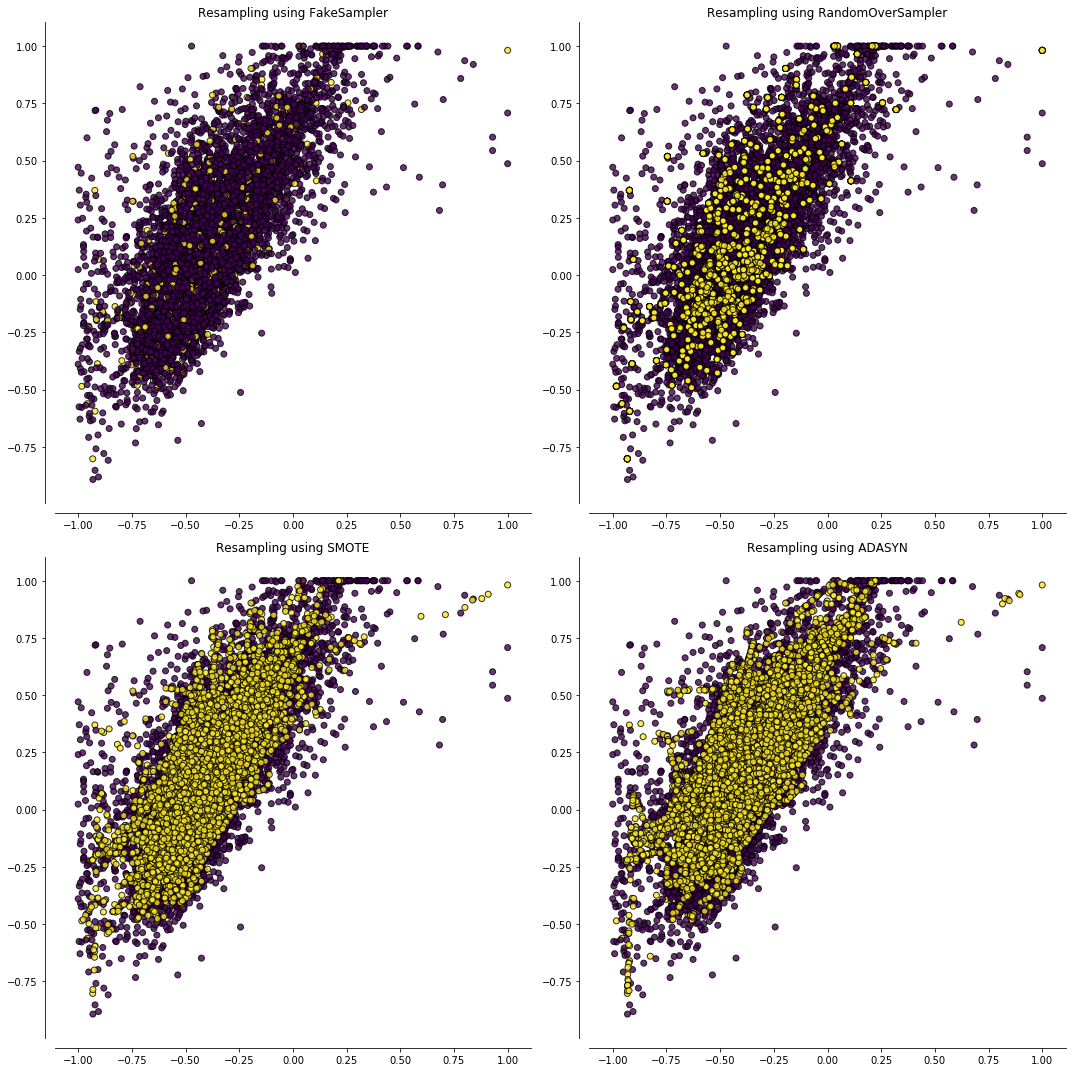

----- FakeSampler -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.98      0.78      0.98      0.88      0.78      1812
          1       0.76      0.78      0.98      0.77      0.88      0.75       138

avg / total       0.97      0.97      0.80      0.97      0.88      0.78      1950

----- RandomUnderSampler -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.91      0.99      0.96      0.95      0.90      1812
          1       0.47      0.99      0.91      0.64      0.95      0.91       138

avg / total       0.96      0.92      0.99      0.93      0.95      0.90      1950

----- ClusterCentroids -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.93      0.94      0.96      0.94      0.87      1812
          1       0.50      0.94      0.93      0.65      0.94      0.88       138

avg / total       0.96      0.93      0.94      0.94      0.94      0.87      1950

----- NearMiss -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.65      0.88      0.78      0.76      0.56      1812
          1       0.16      0.88      0.65      0.27      0.76      0.59       138

avg / total       0.93      0.67      0.87      0.75      0.76      0.56      1950

----- AllKNN -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.97      0.88      0.98      0.93      0.87      1812
          1       0.71      0.88      0.97      0.79      0.93      0.85       138

avg / total       0.97      0.97      0.89      0.97      0.93      0.87      1950

----- EditedNearestNeighbours -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.97      0.87      0.98      0.92      0.85      1812
          1       0.70      0.87      0.97      0.78      0.92      0.84       138

avg / total       0.97      0.96      0.88      0.97      0.92      0.85      1950

----- RepeatedEditedNearestNeighbours -----
Training target statistics: Counter({-1: 5385, 1: 462})
Testing target statistics: Counter({-1: 1812, 1: 138})


KeyboardInterrupt: 

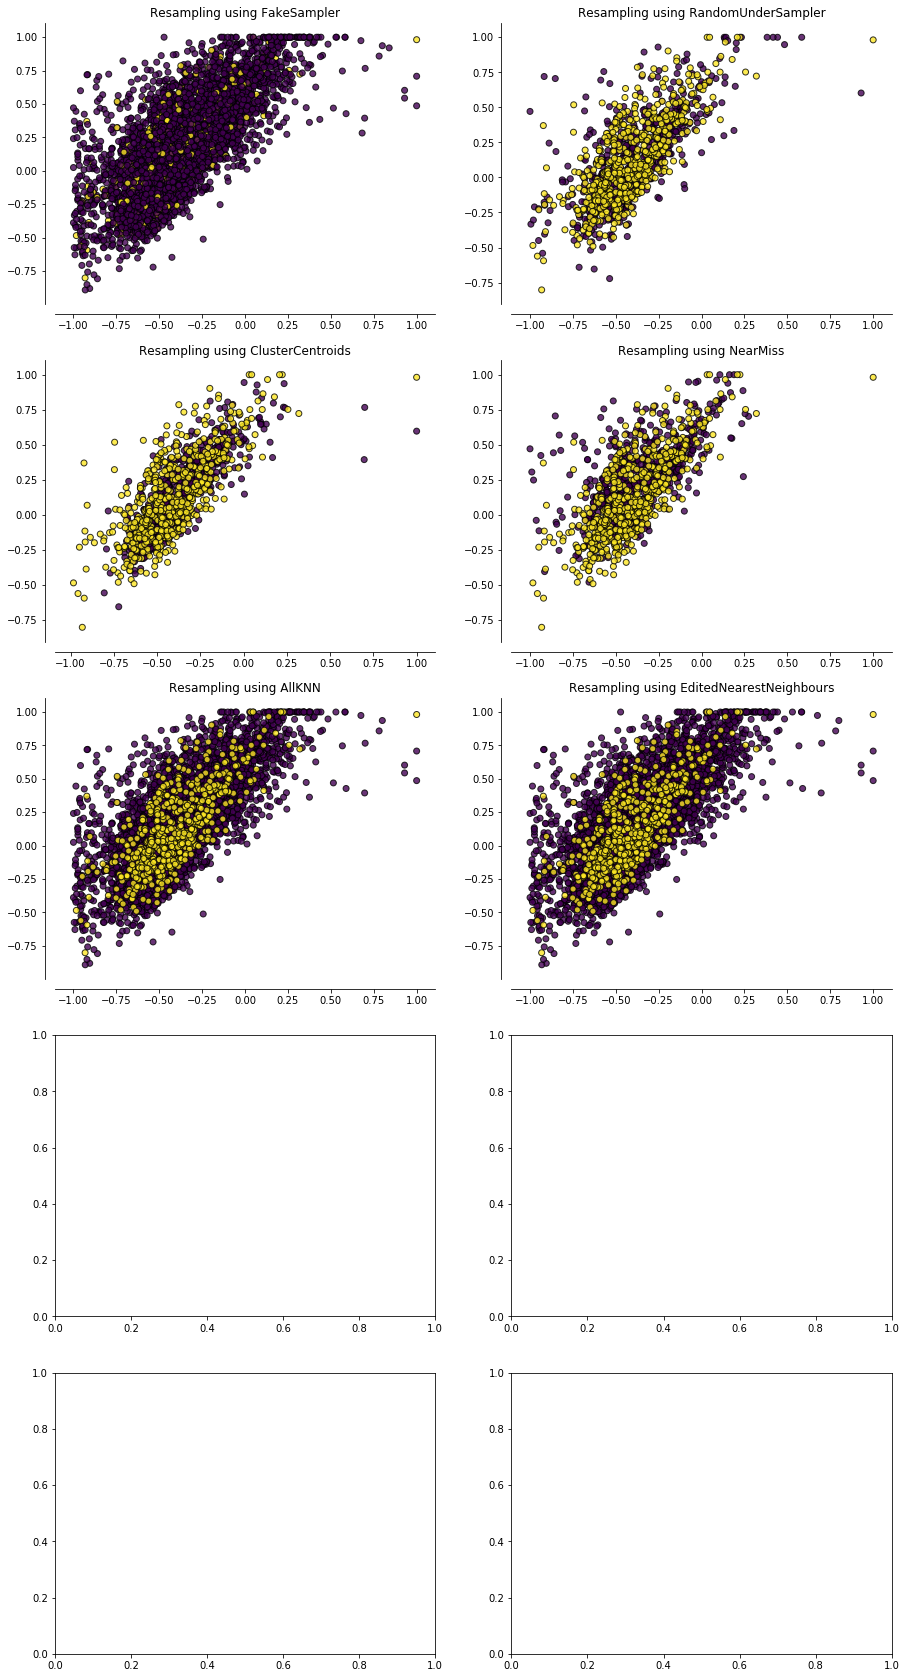

In [38]:
X, y = isolet.data, isolet.target

oversampling_and_classify(X,y)

undersampling_and_classify(X,y)

## Mammography
oversamplingの方が効いている

----- FakeSampler -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      1.00      0.25      0.99      0.50      0.27      2732
          1       0.80      0.25      1.00      0.38      0.50      0.23        64

avg / total       0.98      0.98      0.27      0.98      0.50      0.27      2796

----- RandomOverSampler -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.91      0.86      0.95      0.88      0.78      2732
          1       0.18      0.86      0.91      0.30      0.88      0.78        64

avg / total       0.98      0.91      0.86      0.94      0.88      0.78      2796

----- SMOTE -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.91      0.88      0.95      0.89      0.80      2732
          1       0.18      0.88      0.91      0.31      0.89      0.79        64

avg / total       0.98      0.91      0.88      0.94      0.89      0.80      2796

----- ADASYN -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.82      0.91      0.90      0.86      0.74      2732
          1       0.11      0.91      0.82      0.19      0.86      0.75        64

avg / total       0.98      0.82      0.90      0.88      0.86      0.74      2796



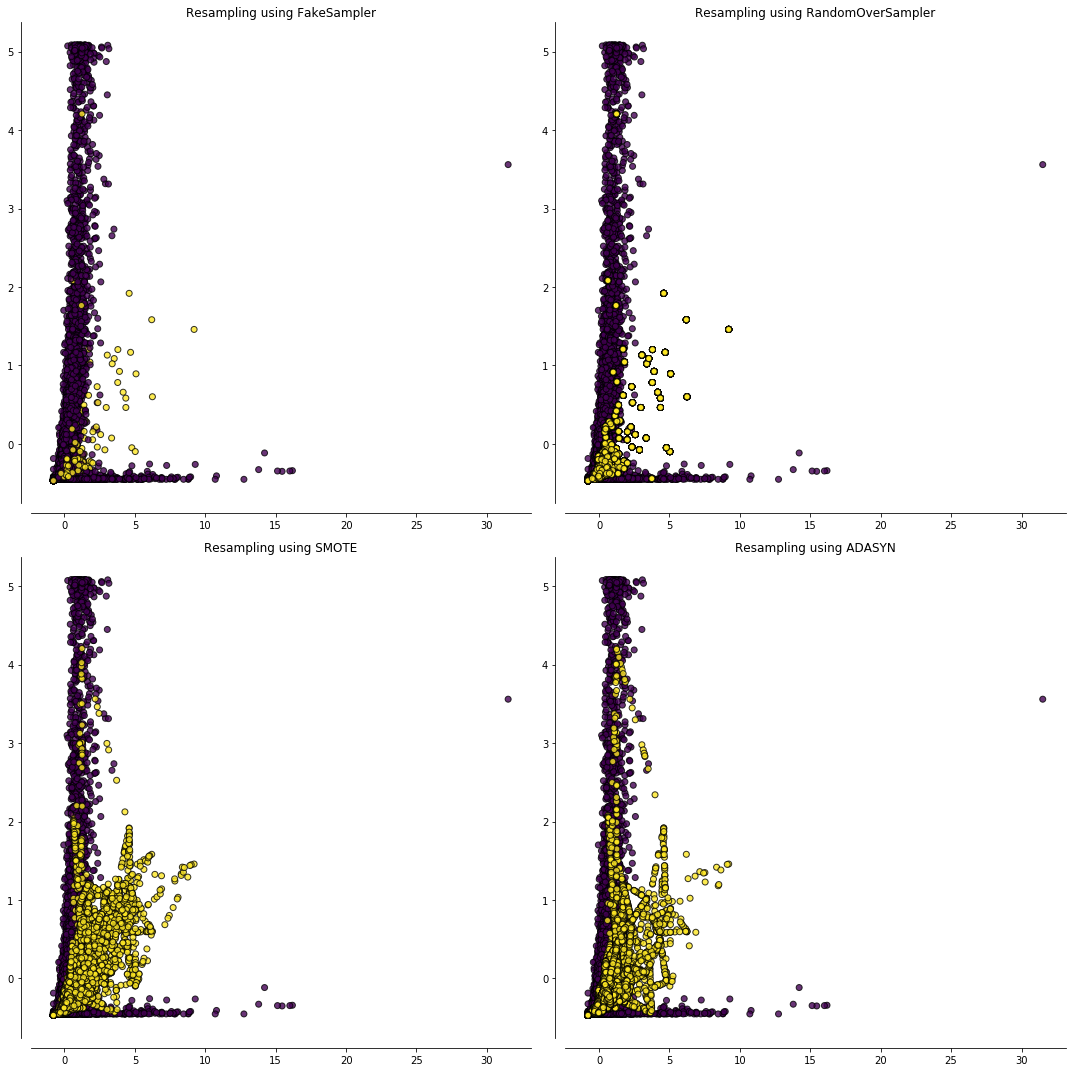

----- FakeSampler -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      1.00      0.25      0.99      0.50      0.27      2732
          1       0.80      0.25      1.00      0.38      0.50      0.23        64

avg / total       0.98      0.98      0.27      0.98      0.50      0.27      2796

----- RandomUnderSampler -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.90      0.81      0.95      0.86      0.74      2732
          1       0.16      0.81      0.90      0.27      0.86      0.73        64

avg / total       0.98      0.90      0.81      0.93      0.86      0.74      2796

----- ClusterCentroids -----
Training target statistics

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was 

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.57      0.78      0.72      0.67      0.44      2732
          1       0.04      0.78      0.57      0.08      0.67      0.45        64

avg / total       0.97      0.57      0.78      0.71      0.67      0.44      2796

----- NearMiss -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.31      0.98      0.47      0.55      0.28      2732
          1       0.03      0.98      0.31      0.06      0.55      0.33        64

avg / total       0.98      0.33      0.97      0.46      0.55      0.29      2796

----- AllKNN -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.36      0.99      0.60      0.38      2732
          1       0.66      0.36      1.00      0.46      0.60      0.34        64

avg / total       0.98      0.98      0.37      0.98      0.60      0.38      2796

----- EditedNearestNeighbours -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.36      0.99      0.60      0.38      2732
          1       0.68      0.36      1.00      0.47      0.60      0.34        64

avg / total       0.98      0.98      0.37      0.98      0.60      0.38      2796

----- RepeatedEditedNearestNeighbours -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.38      0.99      0.61      0.40      2732
          1       0.65      0.38      1.00      0.48      0.61      0.35        64

avg / total       0.98      0.98      0.39      0.98      0.61      0.40      2796

----- CondensedNearestNeighbour -----
Training target statistics: Counter({-1: 8191, 1: 196})
Testing target statistics: Counter({-1: 2732, 1: 64})


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fc4d0629830> (for post_execute):


KeyboardInterrupt: 

In [39]:
X, y = mammography.data, mammography.target

oversampling_and_classify(X,y)

undersampling_and_classify(X,y)

## Arrhythmia
undersamplingの方が効いている

----- FakeSampler -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.96      0.91      0.33      0.93      0.55      0.32       107
          1       0.17      0.33      0.91      0.22      0.55      0.28         6

avg / total       0.92      0.88      0.36      0.89      0.55      0.32       113

----- RandomOverSampler -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.96      0.89      0.33      0.92      0.54      0.31       107
          1       0.14      0.33      0.89      0.20      0.54      0.28         6

avg / total       0.92      0.86      0.36      0.88      0.54      0.31       113

----- SMOTE -----
Training target statistics: Counter({-1: 320, 

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.96      0.91      0.33      0.93      0.55      0.32       107
          1       0.17      0.33      0.91      0.22      0.55      0.28         6

avg / total       0.92      0.88      0.36      0.89      0.55      0.32       113

----- ADASYN -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.96      0.90      0.33      0.93      0.55      0.32       107
          1       0.15      0.33      0.90      0.21      0.55      0.28         6

avg / total       0.92      0.87      0.36      0.89      0.55      0.31       113



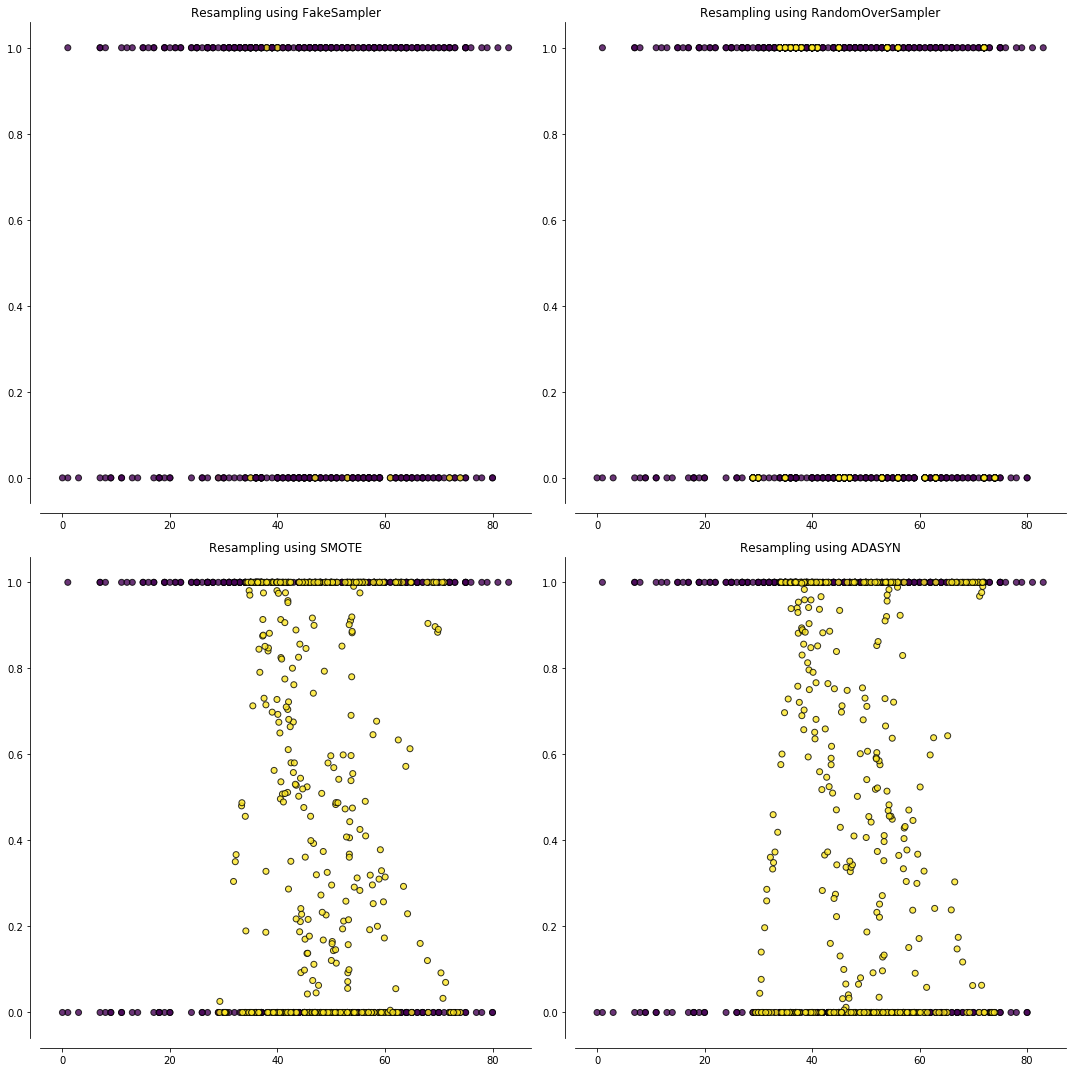

----- FakeSampler -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.96      0.91      0.33      0.93      0.55      0.32       107
          1       0.17      0.33      0.91      0.22      0.55      0.28         6

avg / total       0.92      0.88      0.36      0.89      0.55      0.32       113

----- RandomUnderSampler -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.71      0.83      0.83      0.77      0.58       107
          1       0.14      0.83      0.71      0.24      0.77      0.60         6

avg / total       0.94      0.72      0.83      0.79      0.77      0.59       113

----- ClusterCentroids -----
Training target statistics: Counte

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was 

                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.79      1.00      0.89      0.89      0.78       107
          1       0.21      1.00      0.79      0.35      0.89      0.81         6

avg / total       0.96      0.81      0.99      0.86      0.89      0.78       113

----- NearMiss -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.50      0.83      0.66      0.64      0.40       107
          1       0.08      0.83      0.50      0.15      0.64      0.43         6

avg / total       0.93      0.51      0.82      0.63      0.64      0.40       113

----- AllKNN -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.94      0.67      0.96      0.79      0.65       107
          1       0.40      0.67      0.94      0.50      0.79      0.61         6

avg / total       0.95      0.93      0.68      0.94      0.79      0.64       113

----- EditedNearestNeighbours -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.93      0.67      0.95      0.79      0.63       107
          1       0.33      0.67      0.93      0.44      0.79      0.60         6

avg / total       0.95      0.91      0.68      0.92      0.79      0.63       113

----- RepeatedEditedNearestNeighbours -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.93      0.83      0.96      0.88      0.78       107
          1       0.38      0.83      0.93      0.53      0.88      0.76         6

avg / total       0.96      0.92      0.84      0.93      0.88      0.78       113

----- CondensedNearestNeighbour -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.97      0.90      0.50      0.93      0.67      0.47       107
          1       0.21      0.50      0.90      0.30      0.67      0.43         6

avg / total       0.93      0.88      0.52      0.90      0.67      0.46       113

----- OneSidedSelection -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.96      0.90      0.33      0.93      0.55      0.32       107
          1       0.15      0.33      0.90      0.21      0.55      0.28         6

avg / total       0.92      0.87      0.36      0.89      0.55      0.31       113

----- NeighbourhoodCleaningRule -----
Training target statistics: Counter({-1: 320, 1: 19})
Testing target statistics: Counter({-1: 107, 1: 6})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.96      0.90      0.33      0.93      0.55      0.32       107
          1       0.15      0.33      0.90      0.21      0.55      0.28         6

avg / total       0.92      0.87      0.36      0.89      0.55      0.31       113



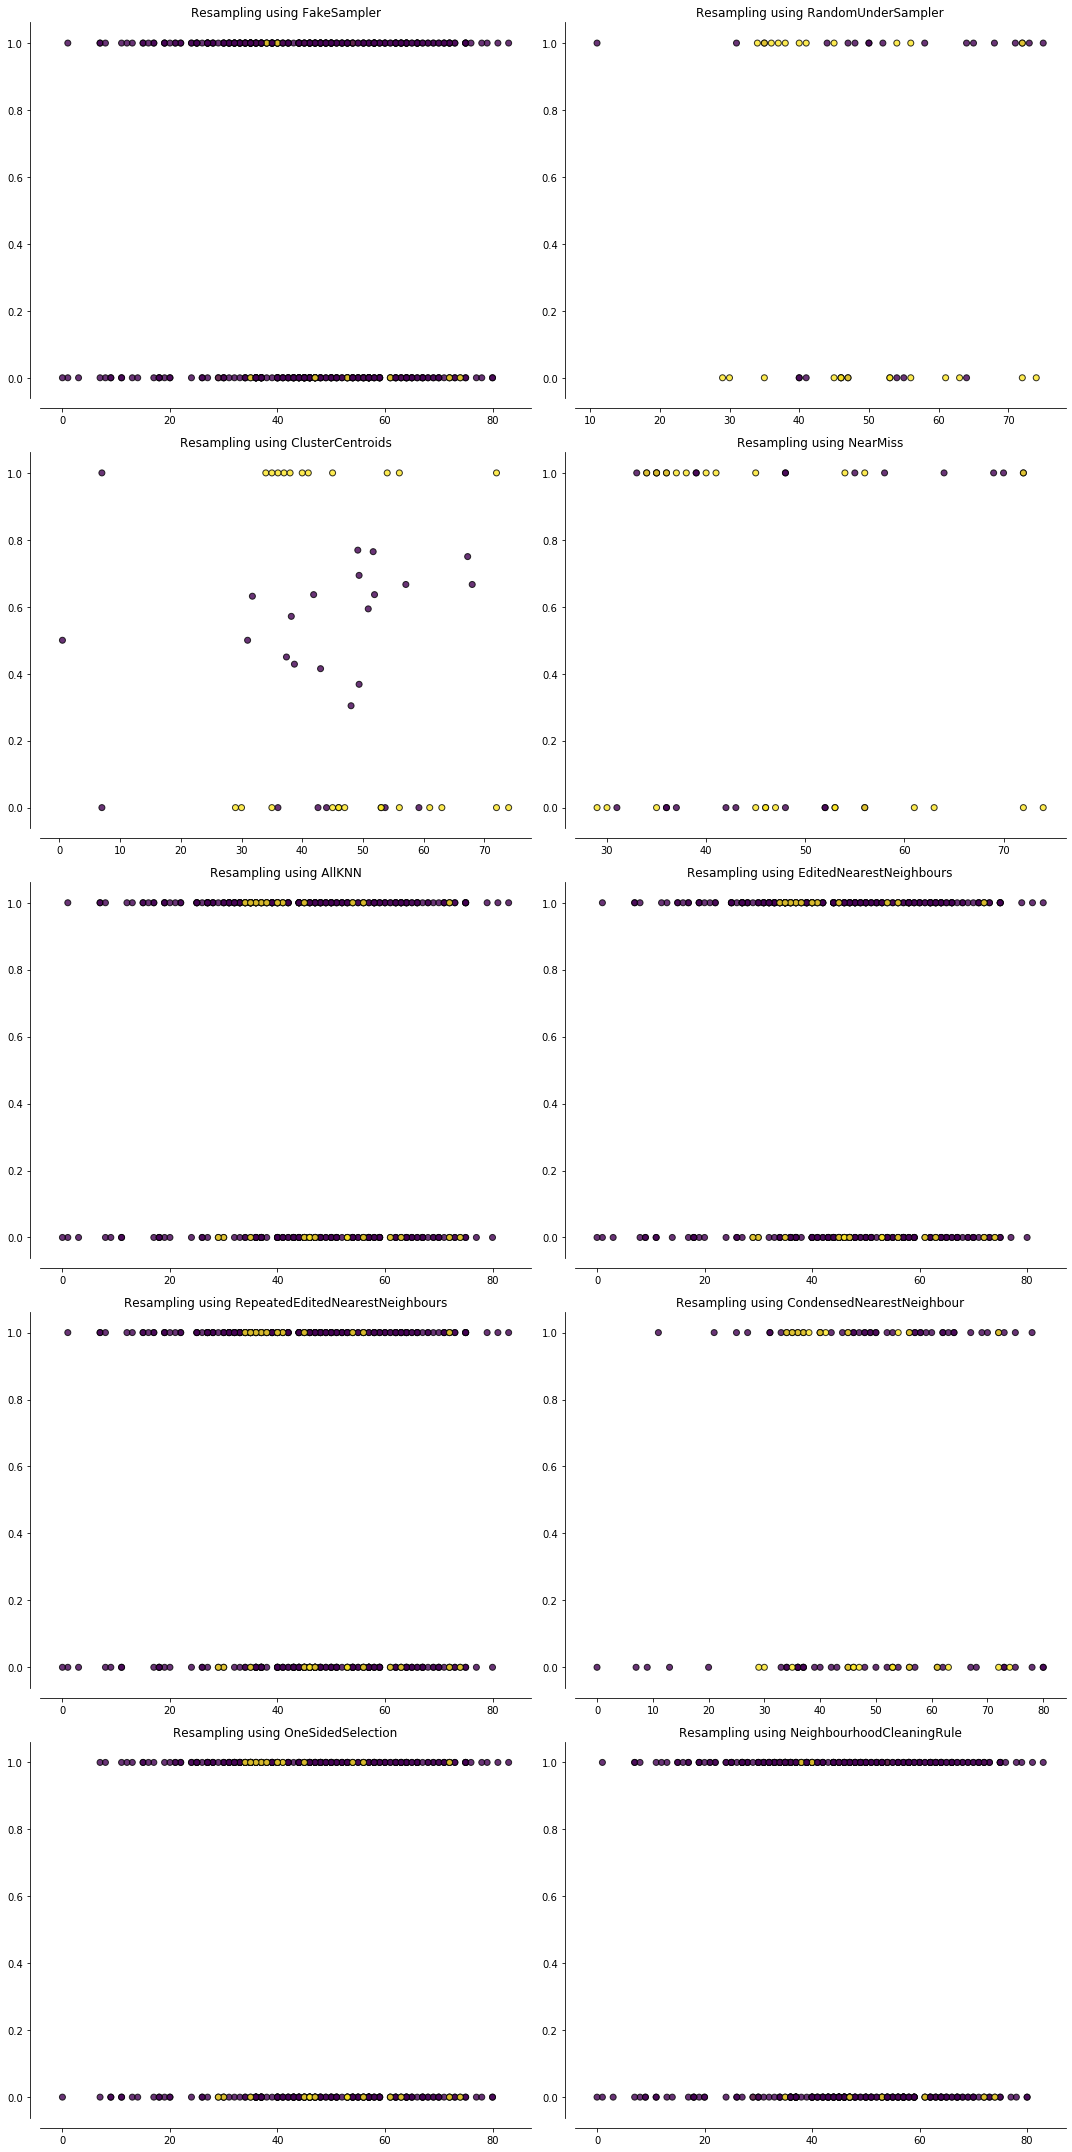

In [40]:
X, y = arrhythmia.data, arrhythmia.target

oversampling_and_classify(X,y)

undersampling_and_classify(X,y)

## Abalone_19
難しい説明変数値の偏りが大きく、そもそも分類が難しいデータのため、サンプリングのみでは精度改善が図れない可能性がある。

----- FakeSampler -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.00      1.00      0.00      0.00      1035
          1       0.00      0.00      1.00      0.00      0.00      0.00        10

avg / total       0.98      0.99      0.01      0.99      0.00      0.00      1045

----- RandomOverSampler -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.82      0.50      0.90      0.64      0.42      1035
          1       0.03      0.50      0.82      0.05      0.64      0.40        10

avg / total       0.98      0.82      0.50      0.89      0.64      0.42      1045

----- SMOTE -----
Training target statistics: Counter({-1:

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.83      0.50      0.90      0.64      0.43      1035
          1       0.03      0.50      0.83      0.05      0.64      0.40        10

avg / total       0.98      0.82      0.50      0.89      0.64      0.43      1045

----- ADASYN -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.83      0.50      0.91      0.64      0.43      1035
          1       0.03      0.50      0.83      0.05      0.64      0.40        10

avg / total       0.98      0.83      0.50      0.90      0.64      0.43      1045



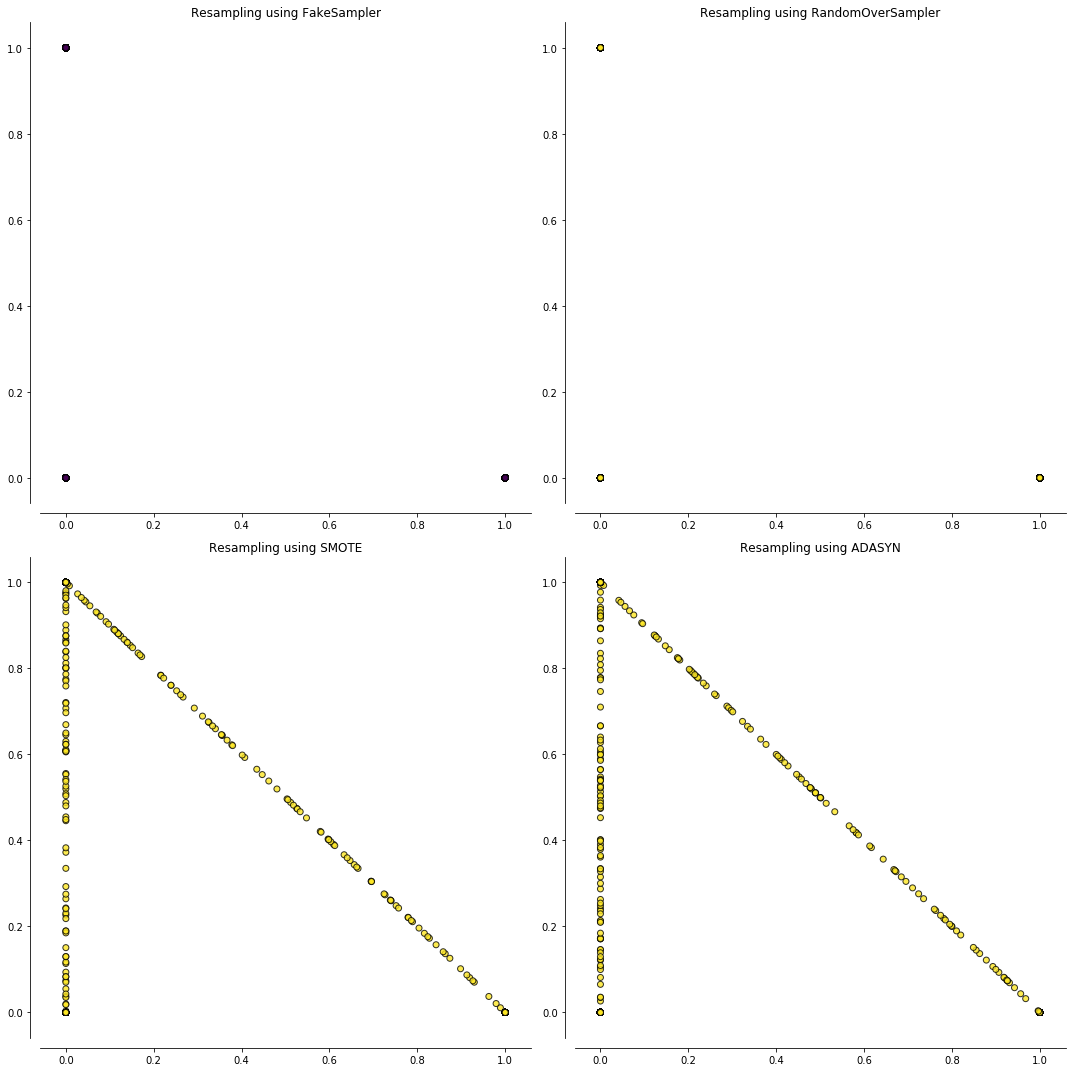

----- FakeSampler -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.00      1.00      0.00      0.00      1035
          1       0.00      0.00      1.00      0.00      0.00      0.00        10

avg / total       0.98      0.99      0.01      0.99      0.00      0.00      1045

----- RandomUnderSampler -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.59      0.80      0.74      0.69      0.46      1035
          1       0.02      0.80      0.59      0.04      0.69      0.48        10

avg / total       0.99      0.59      0.80      0.74      0.69      0.46      1045

----- ClusterCentroids -----
Training target statistics: 

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.71      0.60      0.83      0.65      0.43      1035
          1       0.02      0.60      0.71      0.04      0.65      0.42        10

avg / total       0.99      0.71      0.60      0.82      0.65      0.43      1045

----- NearMiss -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.37      0.70      0.54      0.51      0.25      1035
          1       0.01      0.70      0.37      0.02      0.51      0.27        10

avg / total       0.98      0.37      0.70      0.53      0.51      0.25      1045

----- AllKNN -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.00      1.00      0.00      0.00      1035
          1       0.00      0.00      1.00      0.00      0.00      0.00        10

avg / total       0.98      0.99      0.01      0.99      0.00      0.00      1045

----- EditedNearestNeighbours -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.00      1.00      0.00      0.00      1035
          1       0.00      0.00      1.00      0.00      0.00      0.00        10

avg / total       0.98      0.99      0.01      0.99      0.00      0.00      1045

----- RepeatedEditedNearestNeighbours -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.00      1.00      0.00      0.00      1035
          1       0.00      0.00      1.00      0.00      0.00      0.00        10

avg / total       0.98      0.99      0.01      0.99      0.00      0.00      1045

----- CondensedNearestNeighbour -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.00      1.00      0.00      0.00      1035
          1       0.00      0.00      1.00      0.00      0.00      0.00        10

avg / total       0.98      0.99      0.01      0.99      0.00      0.00      1045

----- OneSidedSelection -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.00      1.00      0.00      0.00      1035
          1       0.00      0.00      1.00      0.00      0.00      0.00        10

avg / total       0.98      0.99      0.01      0.99      0.00      0.00      1045

----- NeighbourhoodCleaningRule -----
Training target statistics: Counter({-1: 3110, 1: 22})
Testing target statistics: Counter({-1: 1035, 1: 10})


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.00      1.00      0.00      0.00      1035
          1       0.00      0.00      1.00      0.00      0.00      0.00        10

avg / total       0.98      0.99      0.01      0.99      0.00      0.00      1045



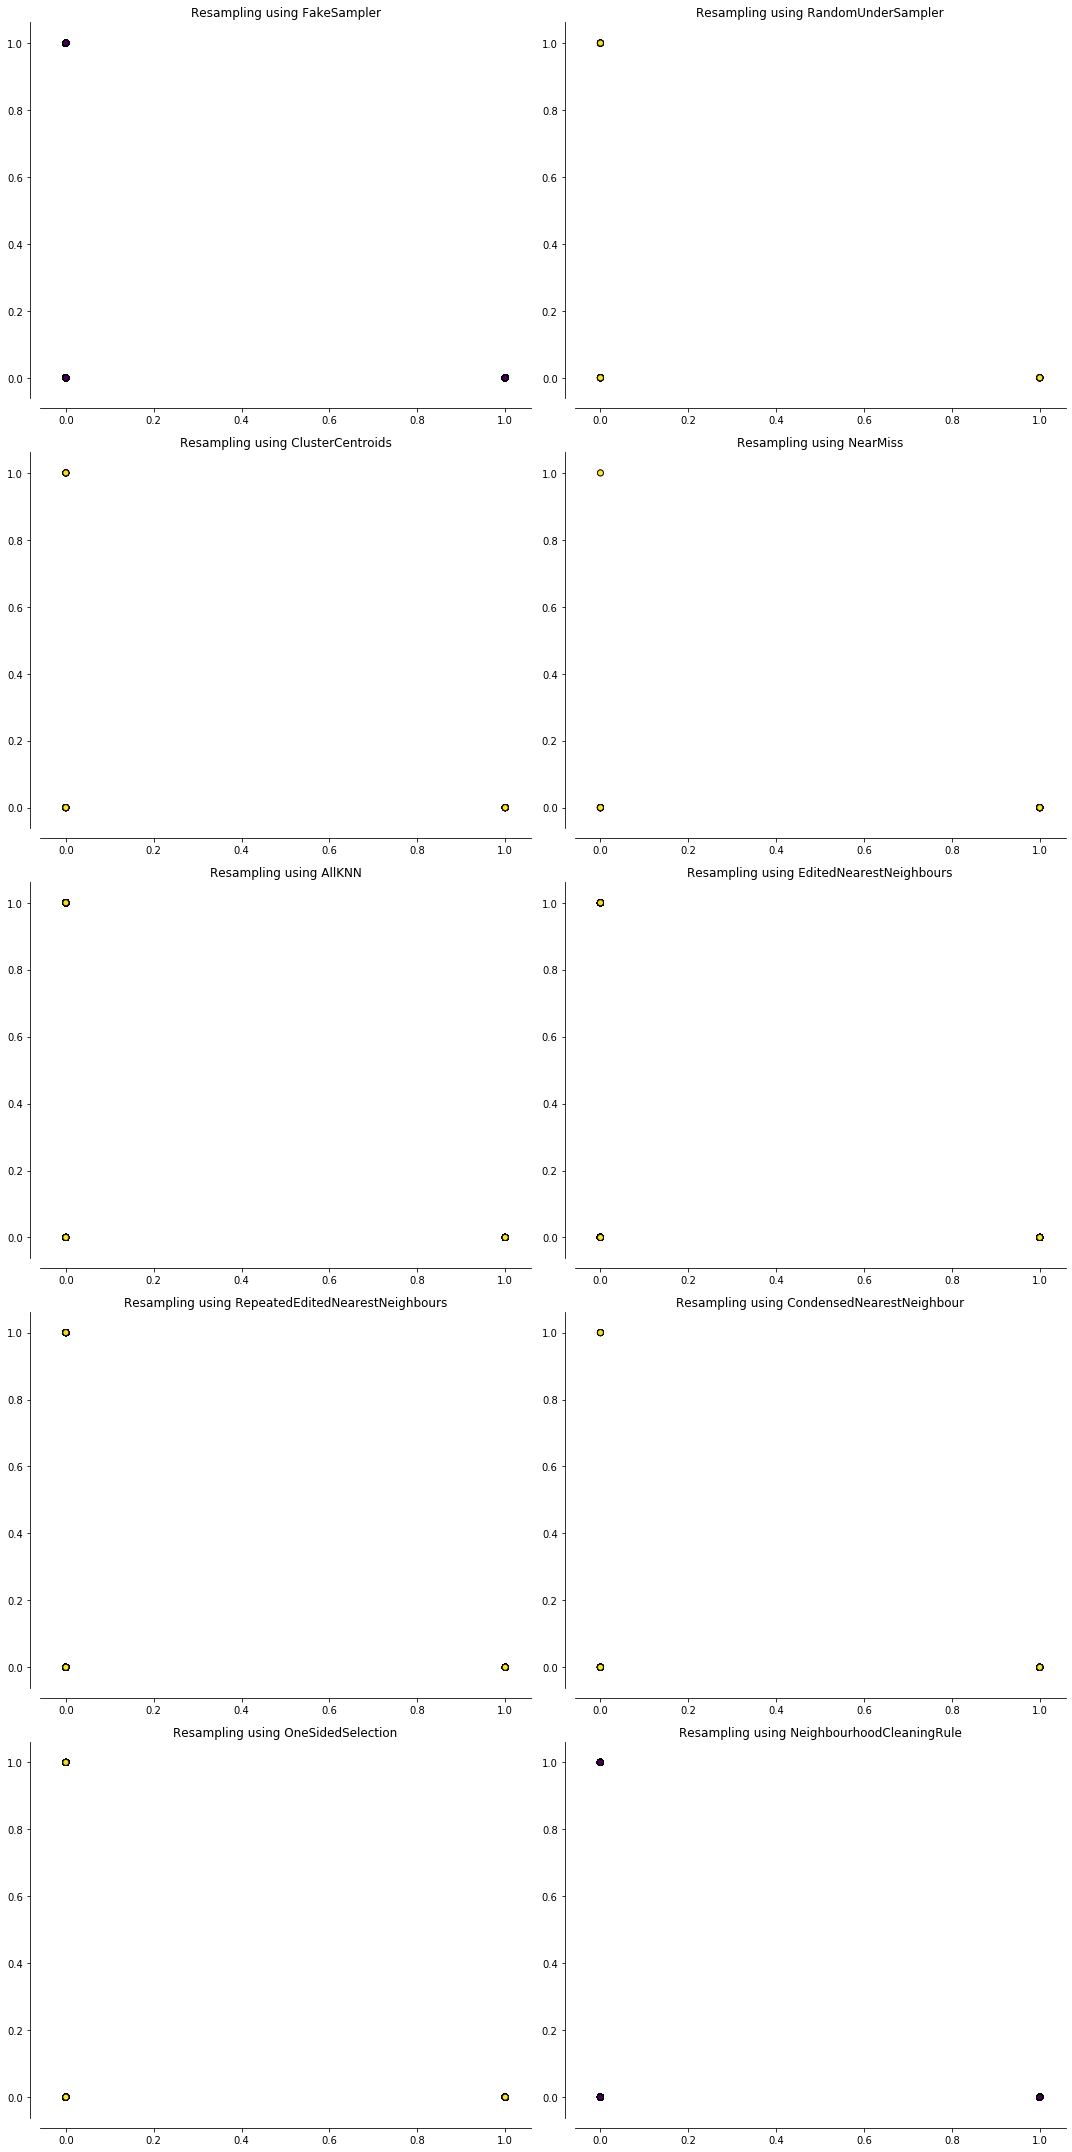

In [42]:
X, y = abalone_19.data, abalone_19.target

oversampling_and_classify(X,y)

undersampling_and_classify(X,y)